In [1]:
import pandas as pd # for data manipulation and analysis
import numpy as np
import requests
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.model_selection import train_test_split # for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Always show DataFrame as plain text in Jupyter
pd.set_option("display.notebook_repr_html", False)


In [2]:
# Option 2: Force column 2 to string
df = pd.read_csv("MTA_Subway_Hourly_Ridership__Beginning_2025_20250923.csv", nrows = 7000000, low_memory = False)

In [3]:
df

              transit_timestamp transit_mode station_complex_id  \
0        01/07/2025 06:00:00 PM       subway                339   
1        01/07/2025 06:00:00 PM       subway                340   
2        01/07/2025 06:00:00 PM       subway                340   
3        01/07/2025 06:00:00 PM       subway                340   
4        01/07/2025 06:00:00 PM       subway                343   
...                         ...          ...                ...   
6999995  03/23/2025 12:00:00 PM       subway                636   
6999996  03/23/2025 12:00:00 PM       subway                 64   
6999997  03/23/2025 12:00:00 PM       subway                 64   
6999998  03/23/2025 12:00:00 PM       subway                 65   
6999999  03/23/2025 12:00:00 PM       subway                 65   

                    station_complex   borough payment_method  \
0                   Bergen St (2,3)  Brooklyn      metrocard   
1            Grand Army Plaza (2,3)  Brooklyn      metrocard   
2  

In [4]:
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

C:\Users\Bagdo\AppData\Local\Temp\ipykernel_1420\3131658029.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


In [5]:
df.shape

(7000000, 12)

In [6]:
df.isnull().sum()

transit_timestamp      0
transit_mode           0
station_complex_id     0
station_complex        0
borough                0
payment_method         0
fare_class_category    0
ridership              0
transfers              0
latitude               0
longitude              0
Georeference           0
dtype: int64

In [7]:
df['station_complex'] = df['station_complex'].str.replace(r'\(.*\)', '', regex=True)

In [8]:
df['month'] = df['transit_timestamp'].dt.month
df['day'] = df['transit_timestamp'].dt.day
df['hour'] = df['transit_timestamp'].dt.hour
df['ridership'] = df['ridership']
df['day_of_week'] = df['transit_timestamp'].dt.dayofweek  # 0=Mon, 6=Sun
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)


In [9]:
df = df.groupby(['month', 'day', 'hour','borough','is_weekend','day_of_week'])['ridership'].sum().reset_index()

In [10]:
df = pd.get_dummies(df, columns=['borough'], prefix='borough')

In [11]:
X = df[['month', 'day', 'hour','borough_Queens','borough_Manhattan','borough_Staten Island','borough_Bronx','borough_Brooklyn','day_of_week',
       'is_weekend']]
y = df['ridership']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Split the data into features and labels
labels = np.array(df['ridership'])
features = df.drop('ridership', axis=1)
feature_list = list(features.columns)
features = np.array(features)

In [13]:
df["borough_Queens"] = df["borough_Queens"].astype(int)
df["borough_Manhattan"] = df["borough_Manhattan"].astype(int)
df["borough_Staten Island"] = df["borough_Staten Island"].astype(int)
df["borough_Bronx"] = df["borough_Bronx"].astype(int)
df["borough_Brooklyn"] = df["borough_Brooklyn"].astype(int)

df["is_weekend"] = df["is_weekend"].astype(int)


In [14]:
features

array([[1, 4, 0, ..., False, False, False],
       [1, 4, 0, ..., False, False, False],
       [1, 4, 0, ..., True, False, False],
       ...,
       [7, 25, 21, ..., True, False, False],
       [7, 25, 22, ..., True, False, False],
       [7, 25, 23, ..., True, False, False]], dtype=object)

In [15]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=38
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor(random_state=38)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                # 3-fold cross validation
    n_jobs=-1,           # use all CPU cores
    verbose=2,
    scoring='r2'         # optimize for R²
)

# Fit grid search to training data
grid_search.fit(train_features, train_labels)


# Best hyperparameters
print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best R² Score:", grid_search.best_score_)


In [21]:
rf_best = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=400,
    random_state=38
)

rf_best.fit(train_features, train_labels)



RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=400,
                      random_state=38)

In [22]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

predictions = rf_best.predict(test_features)

mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
smape = 100 * np.mean(
    2 * np.abs(predictions - test_labels) / (np.abs(test_labels) + np.abs(predictions))
)

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 3))
print("SMAPE:", round(smape, 2), "%")


MAE: 2903.57
RMSE: 7940.28
R²: 0.963
SMAPE: 33.63 %


In [57]:
import joblib

# Save the model
joblib.dump(rf_best, "rf_best_model.pkl")

print("Model saved successfully.")


Model saved successfully.


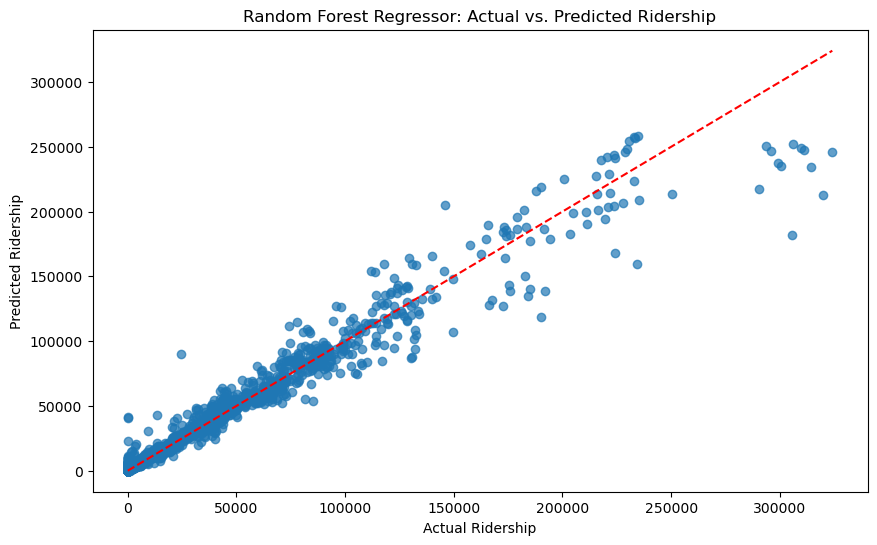

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.7)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')

plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Random Forest Regressor: Actual vs. Predicted Ridership')
plt.show()

month: 0.24629933840117232
day: 0.058390589192784656
hour: 0.3794652151485105
is_weekend: 0.02004113932981861
day_of_week: 0.036758673830466354
borough_Bronx: 0.024615045293072985
borough_Brooklyn: 0.024401961573944538
borough_Manhattan: 0.14534189969349828
borough_Queens: 0.017730882875768083
borough_Staten Island: 0.0469552546609638


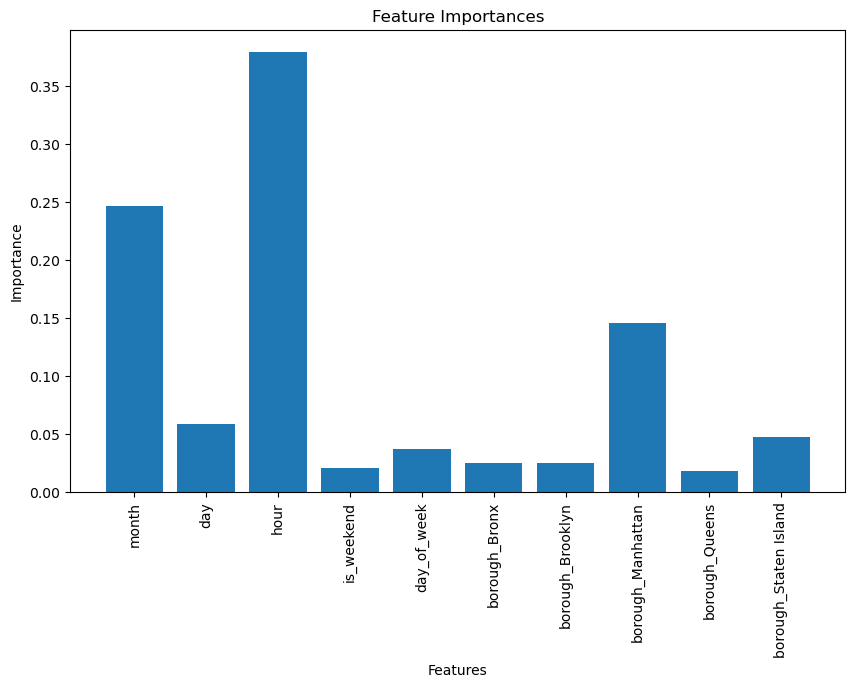

In [24]:
# Train the model on training data
rf_best.fit(train_features, train_labels)

# Get feature importances
feature_importances = rf_best.feature_importances_

# Associate feature importances with feature names
feature_importance_list = list(zip(feature_list, feature_importances))

# Print the top N most important features and their importances
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance}")

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), [feature[0] for feature in feature_importance_list], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [39]:
df

       month  day  hour  is_weekend  day_of_week  ridership  borough_Bronx  \
0          1    4     0           1            5       1163              1   
1          1    4     0           1            5       5272              0   
2          1    4     0           1            5      24702              0   
3          1    4     0           1            5       2823              0   
4          1    4     0           1            5         63              0   
...      ...  ...   ...         ...          ...        ...            ...   
12639      7   25    19           0            4        509              0   
12640      7   25    20           0            4        500              0   
12641      7   25    21           0            4        421              0   
12642      7   25    22           0            4        299              0   
12643      7   25    23           0            4        149              0   

       borough_Brooklyn  borough_Manhattan  borough_Queens  \
0

In [40]:
def predict_and_show_ridership(month, day, hour, borough, day_of_week=None, is_weekend=None):
    # Borough list in same order as columns
    boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    borough_encoding = [1 if b == borough else 0 for b in boroughs]

    # Calculate day_of_week if not provided
    if day_of_week is None:
        try:
            date = pd.Timestamp(year=2025, month=month, day=day)
            day_of_week = date.dayofweek
        except Exception as e:
            print("Invalid date:", e)
            return

    # Calculate is_weekend if not provided
    if is_weekend is None:
        is_weekend = int(day_of_week in [5, 6])

    # Build input in exact column order
    input_data = [[month, day, hour, is_weekend, day_of_week] + borough_encoding]

    # Predict
    predicted_ridership = rf_best.predict(input_data)

    # Find actual ridership if exists
    actual_ridership = df[
        (df['month'] == month) &
        (df['day'] == day) &
        (df['hour'] == hour) &
        (df[f'borough_{borough}'] == 1)
    ]['ridership']

    actual_ridership = actual_ridership.values[0] if len(actual_ridership) > 0 else None

    print(f"Input: Month={month}, Day={day}, Hour={hour}, Borough={borough}, Day_of_week={day_of_week}, Is_weekend={is_weekend}")
    print(f"Predicted Ridership: {round(predicted_ridership[0], 2)}")
    print(f"Actual Ridership: {actual_ridership}")


In [56]:
predict_and_show_ridership(month=2, day=2, hour=1, borough="Brooklyn", day_of_week=2, is_weekend=0)


Input: Month=2, Day=2, Hour=1, Borough=Brooklyn, Day_of_week=2, Is_weekend=0
Predicted Ridership: 1594.06
Actual Ridership: 3596
